# Facebook Friend Recommendation using Graph Mining

In [14]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [15]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [16]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

y_train = pd.read_csv("data/train_y.csv")
y_test = pd.read_csv("data/test_y.csv")

In [17]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [18]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

# Adding new Features

<h3>1. Preferntial Attachment </h3>

In [19]:
def pref_attach_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = len(set(train_graph.successors(a))) * len(set(train_graph.successors(b)))
        return sim
    except:
        return 0

In [20]:
def pref_attach_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = len(set(train_graph.predecessors(a))) * len(set(train_graph.predecessors(b)))
        return sim
    except:
        return 0

<h3>2. SVD Dot</h3>

In [21]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [22]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [23]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [24]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


# Adding New Features

In [25]:
#mapping pref attachment followers to train and test data
df_final_train['pref_attachment_followers'] = df_final_train.apply(lambda row:pref_attach_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['pref_attachment_followers'] = df_final_test.apply(lambda row:pref_attach_for_followers(row['source_node'],row['destination_node']),axis=1)


#mapping pref attach followees to train and test data
df_final_train['pref_attachment_followees'] = df_final_train.apply(lambda row:pref_attach_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['pref_attachment_followees'] = df_final_test.apply(lambda row:pref_attach_for_followees(row['source_node'],row['destination_node']),axis=1)

U_s_train = df_final_train.source_node.apply(lambda x: svd(x, U))
U_d_train = df_final_train.destination_node.apply(lambda x: svd(x, U))

U_s_test = df_final_train.source_node.apply(lambda x: svd(x, U))
U_d_test = df_final_train.destination_node.apply(lambda x: svd(x, U))

df_final_train["U_dot"] = ((df_final_train["svd_u_s_1"] * df_final_train["svd_u_d_1"]) + 
                           (df_final_train["svd_u_s_2"] * df_final_train["svd_u_d_2"]) + 
                           (df_final_train["svd_u_s_3"] * df_final_train["svd_u_d_3"]) + 
                           (df_final_train["svd_u_s_4"] * df_final_train["svd_u_d_4"]) + 
                           (df_final_train["svd_u_s_5"] * df_final_train["svd_u_d_5"]) + 
                           (df_final_train["svd_u_s_6"] * df_final_train["svd_u_d_6"]))
                    
df_final_test["U_dot"] = ((df_final_test["svd_u_s_1"] * df_final_test["svd_u_d_1"]) + 
                          (df_final_test["svd_u_s_2"] * df_final_test["svd_u_d_2"]) + 
                          (df_final_test["svd_u_s_3"] * df_final_test["svd_u_d_3"]) +  
                          (df_final_test["svd_u_s_4"] * df_final_test["svd_u_d_4"]) + 
                          (df_final_test["svd_u_s_5"] * df_final_test["svd_u_d_5"]) + 
                          (df_final_test["svd_u_s_6"] * df_final_test["svd_u_d_6"]))
                    
df_final_train["V_dot"] = ((df_final_train["svd_v_s_1"] * df_final_train["svd_v_d_1"]) + 
                          (df_final_train["svd_v_s_2"] * df_final_train["svd_v_d_2"]) + 
                          (df_final_train["svd_v_s_3"] * df_final_train["svd_v_d_3"]) + 
                          (df_final_train["svd_v_s_4"] * df_final_train["svd_v_d_4"]) + 
                          (df_final_train["svd_v_s_5"] * df_final_train["svd_v_d_5"]) + 
                          (df_final_train["svd_v_s_6"] * df_final_train["svd_v_d_6"]))

df_final_test["V_dot"] = ((df_final_test["svd_v_s_1"] * df_final_test["svd_v_d_1"]) + 
                          (df_final_test["svd_v_s_2"] * df_final_test["svd_v_d_2"]) + 
                          (df_final_test["svd_v_s_3"] * df_final_test["svd_v_d_3"]) + 
                          (df_final_test["svd_v_s_4"] * df_final_test["svd_v_d_4"]) + 
                          (df_final_test["svd_v_s_5"] * df_final_test["svd_v_d_5"]) + 
                          (df_final_test["svd_v_s_6"] * df_final_test["svd_v_d_6"]))

In [26]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [ ]:
xgb_clf = XGBClassifier(objective='binary:logistic', n_jobs= -1)

param_distributions = {
    'alpha' : [10**-5, 10**-4, 10**-3, 10**-2, 10**-1],
    'max_depth' : [1, 2, 4, 8, 16],
    'n_estimators' : [32, 64, 100, 200]
    }

skf = StratifiedKFold(n_splits=3, shuffle = True)

rsc = RandomizedSearchCV(xgb_clf,
                         param_distributions,
                         n_iter=10,
                         scoring='f1',
                         cv=skf.split(df_final_train, y_train),
                         verbose = 3,
                         n_jobs=-1)


rsc.fit(df_final_train,y_train)

In [28]:
print('mean test scores',rsc.cv_results_['mean_test_score'])
print('mean train scores',rsc.cv_results_['mean_train_score'])

mean test scores [0.97329891 0.97800625 0.97800625 0.92487248 0.98077457 0.97776414
 0.97648491 0.97430017 0.97550141 0.9789769 ]
mean train scores [0.97351189 0.99954027 0.99954027 0.92484282 0.99820935 0.98075727
 0.99770326 0.97511383 0.97885596 0.999995  ]


In [29]:
print(rsc.best_estimator_)

XGBClassifier(alpha=1e-05, base_score=0.5, booster='gbtree',
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)


In [30]:
clf = XGBClassifier(alpha=1e-05, base_score=0.5, booster='gbtree',
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [31]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [32]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9955305247123902
Test f1 score 0.9264477738816279


In [33]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


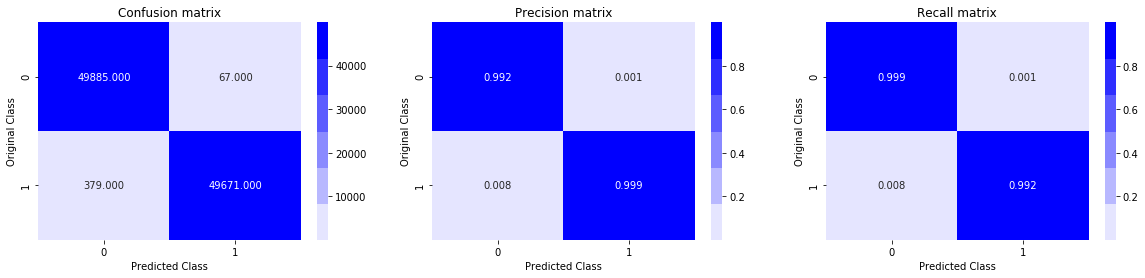

Test confusion_matrix


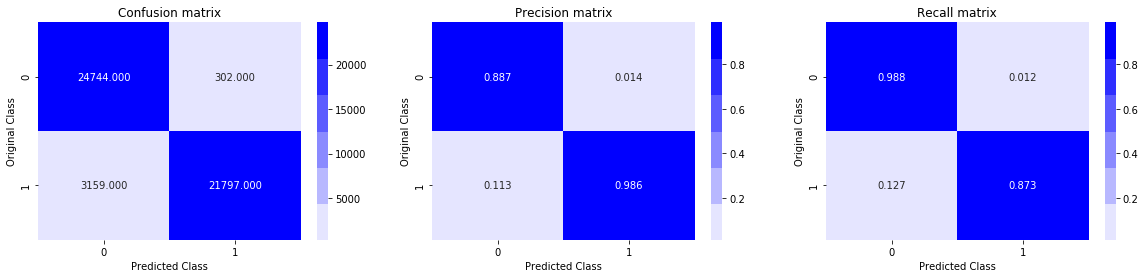

In [34]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

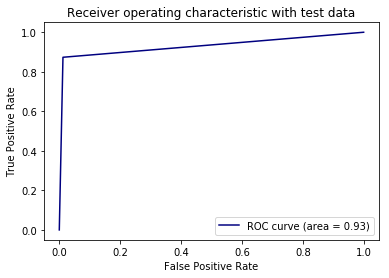

In [35]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

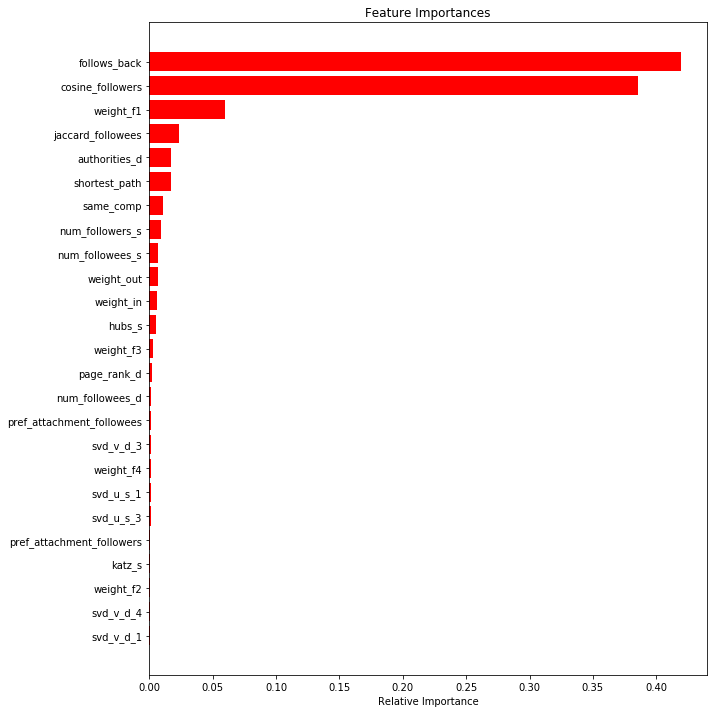

In [36]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Conclusion :
    1. After adding Preferntial Attachment score, there is no significant increase in the F1 Score for test data.
    2. XGB Classifier is overfitting this data.
    2. from feature importance it is clear that Preferntial Attachment score and SVD Dot features are not adding that
       much value to overall classification problem.